In [1]:
from os import makedirs
from os.path import join, isdir

import torch
import torchvision

import matplotlib.pyplot as plt

In [2]:
scale = 4
plots_folder = join("plots")


def save_plot(filename: str, folder_path: str):
    if not isdir(folder_path):
        makedirs(folder_path)
    for extension in ["png", "svg"]:
        if not isdir(join(folder_path, extension)):
            makedirs(join(folder_path, extension))
        plt.savefig(join(folder_path, extension, f"{filename}.{extension}"))

In [29]:
from quantization import quantization_fn


def plot_quantization_function(quantization_bits, range_clip=1, n_values=128):
    weights = torch.linspace(-range_clip, range_clip, n_values)
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(scale, scale))
    ax.set_xlabel("weight magnitude")
    ax.set_ylabel("weight magnitude quantized")
    for r in [0.001, 0.25, 0.75, 1]:
        weights_quantized = quantization_fn(weights.clone(),
                                            r=r, quantization_bits=quantization_bits, range_clip=range_clip)
        ax.plot(weights, weights_quantized, label=f"$r = {r}$")
    ax.set_title(f"{quantization_bits}-bit quantization function")
    plt.legend()
    save_plot(filename=f"quantization_fn_{quantization_bits}bits", folder_path=plots_folder)
    plt.show()

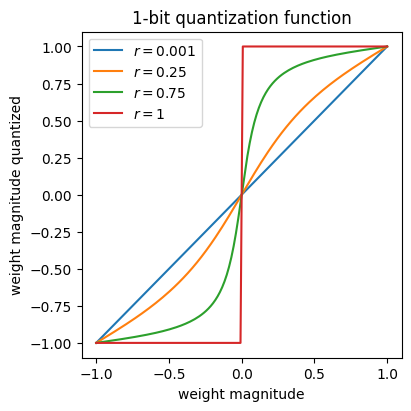

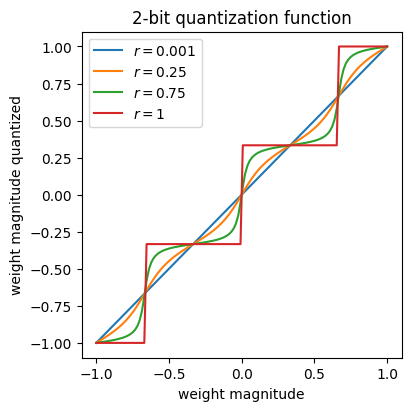

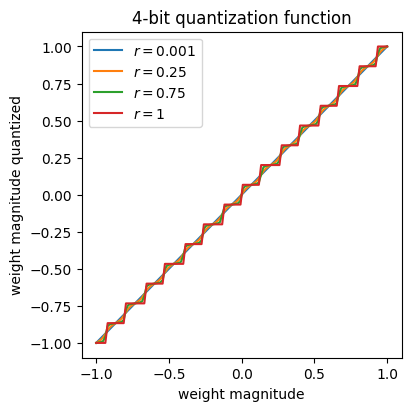

In [30]:
plot_quantization_function(quantization_bits=1)
plot_quantization_function(quantization_bits=2)
plot_quantization_function(quantization_bits=4)

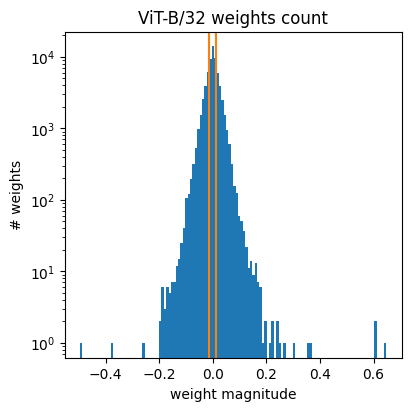

In [33]:
import numpy as np
from utils import get_flattened_weights

pruning_percent = 0.5
model = torchvision.models.vit_b_32()
model.load_state_dict(torch.load(join("models", "weights", "imagenet", "vit_b_32.pth")))
weights = get_flattened_weights(model)
weights = weights[torch.linspace(0, len(weights), steps=2 ** 16, dtype=torch.long)]
left_margin = np.percentile(weights, ((1 - pruning_percent) / 2) * 100)
right_margin = np.percentile(weights, (pruning_percent + (1 - pruning_percent) / 2) * 100)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(scale, scale))
ax.set_xlabel("weight magnitude")
ax.set_ylabel("# weights")
ax.set_yscale("log")
ax.hist(weights, bins=128)
# ax.hist([weights[weights < left_margin], weights[(weights < left_margin) & (weights > right_margin)], weights[weights > right_margin]], color=["tab:blue", "tab:orange", "tab:blue"], bins=128)
ax.axvline(x=left_margin, color="tab:orange", label='axvline - full height')
ax.axvline(x=right_margin, color="tab:orange", label='axvline - full height')
ax.set_title(f"ViT-B/32 weights count")
save_plot(filename=f"pruned_weights", folder_path=plots_folder)
plt.show()